# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot


## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putrimentari","key":"8ea4ea29f73afd2cf8b1ed0efe6ae519"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images --force
!unzip -o shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

In [ ]:
# Melihat jumlah citra dan ukuran resolusi

from PIL import Image
import os

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [ ]:
print_images_resolution("Shoe vs Sandal vs Boot Dataset")

Boot: 5000
- (136, 102)
---------------
Sandal: 5000
- (136, 102)
- (135, 102)
---------------
Shoe: 5000
- (136, 102)
- (135, 102)
---------------

Total: 15000


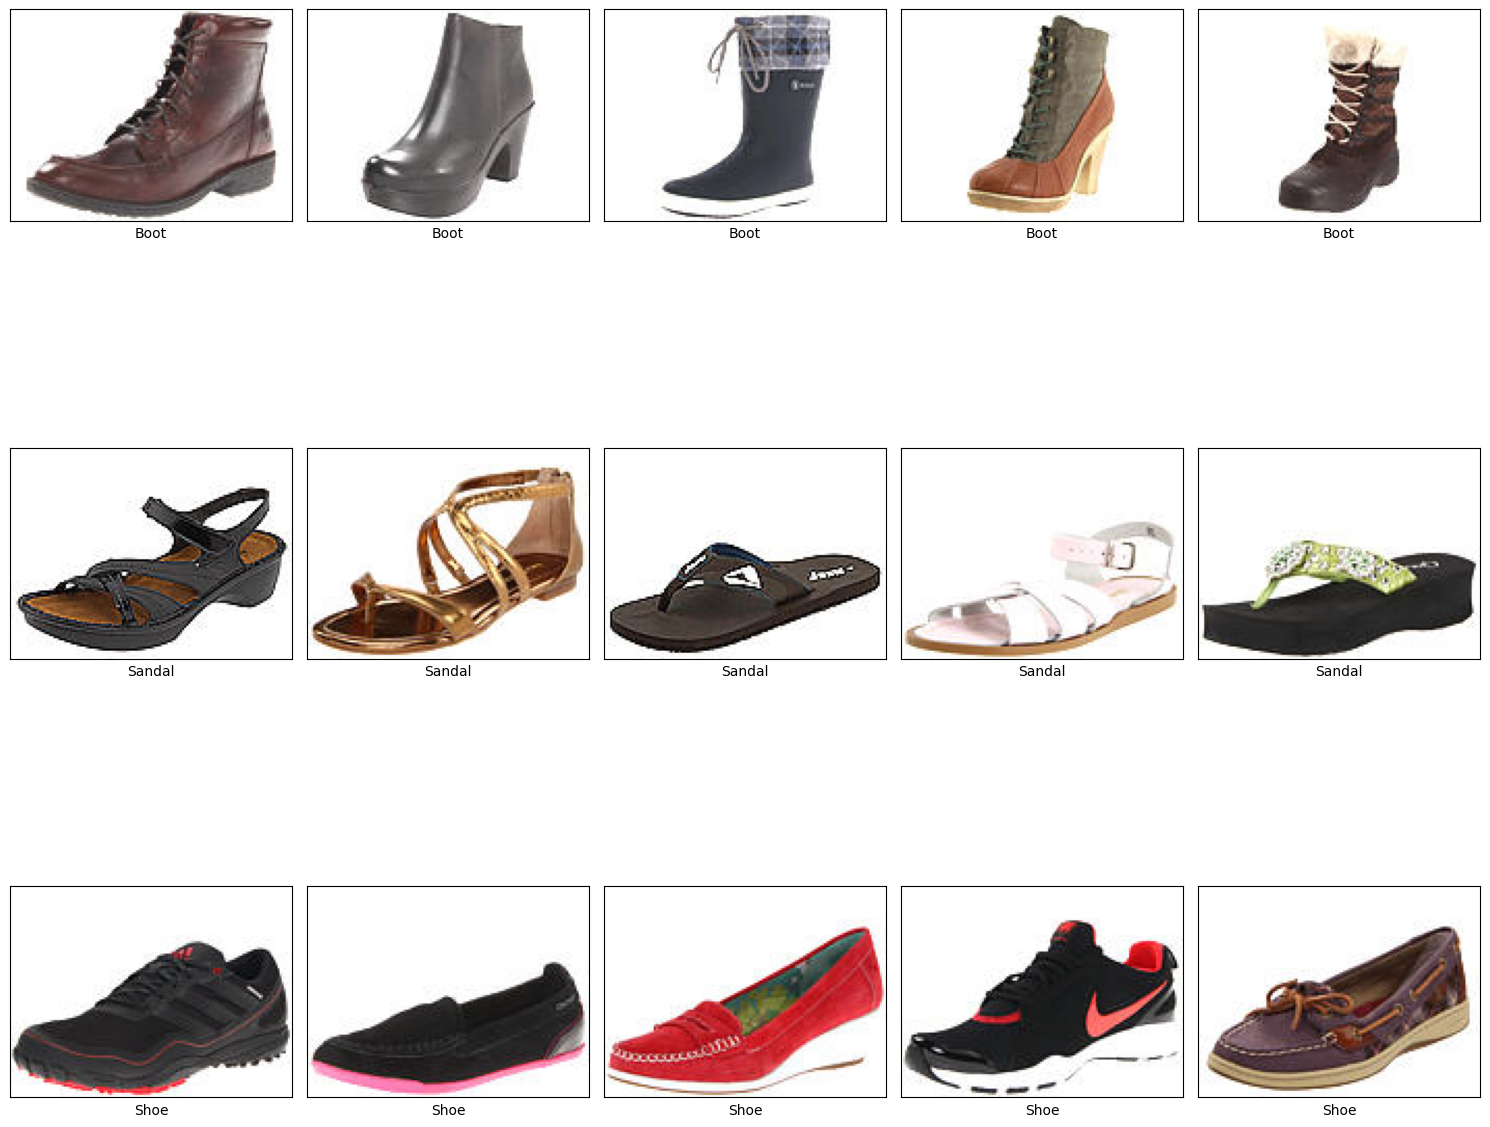

In [ ]:
# Gambar Sampel Setiap Kelas

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
shoe_image = {}

# Tentukan path sumber train
path = "Shoe vs Sandal vs Boot Dataset"
for i in os.listdir(path):
    shoe_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data.
path = "Shoe vs Sandal vs Boot Dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(shoe_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(shoe_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

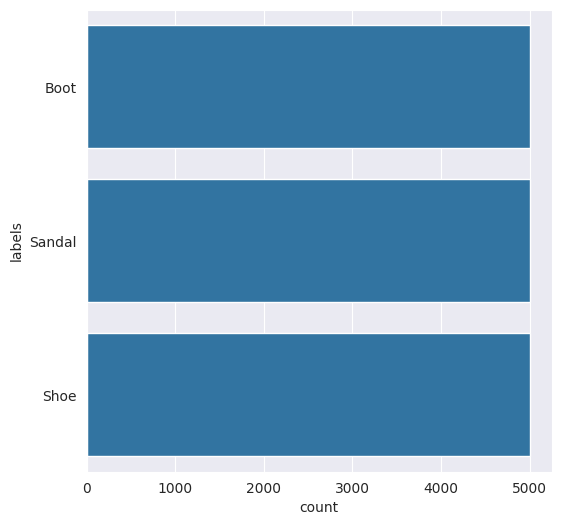

In [ ]:
# Plot Distribusi Gambar

# Menentukan path sumber
shoe_path = "Shoe vs Sandal vs Boot Dataset"

# Membuat daftar yang menyimpan data untuk setiap filenames, filepaths, dan labels dalam data
file_name = []
labels = []
full_path = []

# Mendapatkan data filenames, filepaths, labels satu per satu dengan looping, dan disimpan sebagai dataframe
for path, subdirs, files in os.walk(shoe_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = "Shoe vs Sandal vs Boot Dataset"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Boot,5000
Sandal,5000
Shoe,5000


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 12000
test size 3000


Pada tahap ini, data dibagi menjadi train dan test sementara data validation akan dibuat menggunakan ImageDataGenerator()

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels
test   Boot       951
       Sandal    1062
       Shoe       987
train  Boot      4049
       Sandal    3938
       Shoe      4013
dtype: int64 


                                                    path  labels    set
7319   Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1500...    Shoe  train
4602   Shoe vs Sandal vs Boot Dataset/Boot/boot (4412...    Boot  train
11105  Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (...  Sandal  train
3611   Shoe vs Sandal vs Boot Dataset/Boot/boot (4961...    Boot  train
9614   Shoe vs Sandal vs Boot Dataset/Boot/boot (4742...    Boot  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Shoe vs Sandal vs Boot Dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Data Augmentation

In [ ]:
TRAIN_DIR = "Dataset/train/"
TEST_DIR = "Dataset/test/"

train_shoe = os.path.join(TRAIN_DIR + '/Shoe')
train_sandal = os.path.join(TRAIN_DIR + '/Sandal')
train_boot = os.path.join(TRAIN_DIR + '/Boot')

test_shoe = os.path.join(TEST_DIR + '/Shoe')
test_sandal = os.path.join(TEST_DIR + '/Sandal')
test_boot = os.path.join(TEST_DIR + '/Boot')

print("Total number of shoe images in training set: ",len(os.listdir(train_shoe)))
print("Total number of sandal images in training set: ",len(os.listdir(train_sandal)))
print("Total number of boot images in training set: ",len(os.listdir(train_boot)))

print("Total number of shoe images in test set: ",len(os.listdir(test_shoe)))
print("Total number of sandal images in test set: ",len(os.listdir(test_sandal)))
print("Total number of boot images in test set: ",len(os.listdir(test_boot)))

Total number of shoe images in training set:  4013
Total number of sandal images in training set:  3938
Total number of boot images in training set:  4049
Total number of shoe images in test set:  987
Total number of sandal images in test set:  1062
Total number of boot images in test set:  951


In [ ]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest',
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 9602 images belonging to 3 classes.
Found 2398 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


## Modelling

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Output Layer untuk 3 classes
model_1.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ########################################
model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,587 (5.35 MB)

 Trainable params: 1,403,395 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
# Menghitung jumlah gambar pada setiap kelas
count_shoe, count_sandal, count_boot, = len(os.listdir(train_shoe)), len(os.listdir(train_sandal)), len(os.listdir(train_boot))

# Menghitung class weights
weight_shoe = (1 / count_shoe) * (count_shoe + count_sandal + count_boot) / 3.0
weight_sandal = (1 / count_sandal) * (count_sandal + count_shoe + count_boot) / 3.0
weight_boot = (1 / count_boot) * (count_boot + count_shoe + count_sandal) / 3.0

class_weights = {
    0: weight_shoe,
    1: weight_sandal,
    2: weight_boot,
}

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 15 µs


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=100,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5512 - loss: 1.1458

301/301 ━━━━━━━━━━━━━━━━━━━━ 90s 274ms/step - accuracy: 0.5513 - loss: 1.1451 - val_accuracy: 0.5847 - val_loss: 0.9730
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6879 - loss: 0.7424

301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 253ms/step - accuracy: 0.6880 - loss: 0.7424 - val_accuracy: 0.7898 - val_loss: 0.5272
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.7200 - loss: 0.6731 - val_accuracy: 0.7736 - val_loss: 0.5333
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7566 - loss: 0.6017

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.7566 - loss: 0.6017 - val_accuracy: 0.8286 - val_loss: 0.4843
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7818 - loss: 0.5373

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.7818 - loss: 0.5374 - val_accuracy: 0.8428 - val_loss: 0.4146
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.7942 - loss: 0.5273 - val_accuracy: 0.8415 - val_loss: 0.4258
Epoch 7/100
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8151 - loss: 0.4860

301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - accuracy: 0.8151 - loss: 0.4859 - val_accuracy: 0.8774 - val_loss: 0.3318
Epoch 8/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.8343 - loss: 0.4472 - val_accuracy: 0.8599 - val_loss: 0.3933
Epoch 9/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.8387 - loss: 0.4178 - val_accuracy: 0.8691 - val_loss: 0.3396
Epoch 10/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8553 - loss: 0.3939 - val_accuracy: 0.8528 - val_loss: 0.4094
Epoch 11/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 254ms/step - accuracy: 0.8666 - loss: 0.3784 - val_accuracy: 0.8628 - val_loss: 0.3744
Epoch 12/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8709 - loss: 0.3656

301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8709 - loss: 0.3656 - val_accuracy: 0.9166 - val_loss: 0.2551
Epoch 13/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.8771 - loss: 0.3424 - val_accuracy: 0.8957 - val_loss: 0.2980
Epoch 14/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8863 - loss: 0.3152 - val_accuracy: 0.8724 - val_loss: 0.3781
Epoch 15/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8813 - loss: 0.3395 - val_accuracy: 0.8803 - val_loss: 0.4043
Epoch 16/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8934 - loss: 0.3268

301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 251ms/step - accuracy: 0.8934 - loss: 0.3267 - val_accuracy: 0.9133 - val_loss: 0.2545
Epoch 17/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.8909 - loss: 0.3081 - val_accuracy: 0.9103 - val_loss: 0.2569
Epoch 18/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8966 - loss: 0.2986

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.8966 - loss: 0.2986 - val_accuracy: 0.9254 - val_loss: 0.2434
Epoch 19/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9148 - loss: 0.2582

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9147 - loss: 0.2583 - val_accuracy: 0.9183 - val_loss: 0.2205
Epoch 20/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9058 - loss: 0.2715 - val_accuracy: 0.9099 - val_loss: 0.2374
Epoch 21/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.9057 - loss: 0.2725 - val_accuracy: 0.9149 - val_loss: 0.2492
Epoch 22/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 248ms/step - accuracy: 0.9054 - loss: 0.2768 - val_accuracy: 0.9174 - val_loss: 0.2388
Epoch 23/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.9216 - loss: 0.2415 - val_accuracy: 0.9049 - val_loss: 0.3861
Epoch 24/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9227 - loss: 0.2329

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.9227 - loss: 0.2329 - val_accuracy: 0.9341 - val_loss: 0.1790
Epoch 25/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.9218 - loss: 0.2483 - val_accuracy: 0.8728 - val_loss: 0.3202
Epoch 26/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - accuracy: 0.9189 - loss: 0.2458 - val_accuracy: 0.9237 - val_loss: 0.2299
Epoch 27/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 255ms/step - accuracy: 0.9257 - loss: 0.2287 - val_accuracy: 0.8757 - val_loss: 0.3435
Epoch 28/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.9249 - loss: 0.2235 - val_accuracy: 0.9158 - val_loss: 0.2775
Epoch 29/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - accuracy: 0.9285 - loss: 0.2239 - val_accuracy: 0.9216 - val_loss: 0.2563
Epoch 30/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.9275 - loss: 0.2203 - val_accuracy: 0.9062 - val_loss: 0.2417
Epoch 31/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9329 - loss

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.9341 - loss: 0.2108 - val_accuracy: 0.9370 - val_loss: 0.1755
Epoch 34/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.9333 - loss: 0.2008 - val_accuracy: 0.9379 - val_loss: 0.1869
Epoch 35/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9375 - loss: 0.1960 - val_accuracy: 0.9062 - val_loss: 0.3387
Epoch 36/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - accuracy: 0.9302 - loss: 0.2089 - val_accuracy: 0.9170 - val_loss: 0.2265
Epoch 37/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9370 - loss: 0.1967 - val_accuracy: 0.9337 - val_loss: 0.2509
Epoch 38/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9322 - loss: 0.1988 - val_accuracy: 0.9395 - val_loss: 0.2005
Epoch 39/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9343 - loss: 0.1996 - val_accuracy: 0.9208 - val_loss: 0.2285
Epoch 40/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9397 - loss:

301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9397 - loss: 0.1747 - val_accuracy: 0.9516 - val_loss: 0.1436
Epoch 41/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9378 - loss: 0.1853 - val_accuracy: 0.9495 - val_loss: 0.1519
Epoch 42/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9406 - loss: 0.1851 - val_accuracy: 0.9525 - val_loss: 0.1578
Epoch 43/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9342 - loss: 0.1983 - val_accuracy: 0.8870 - val_loss: 0.2815
Epoch 44/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9397 - loss: 0.1892 - val_accuracy: 0.9412 - val_loss: 0.1619
Epoch 45/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 246ms/step - accuracy: 0.9410 - loss: 0.1847 - val_accuracy: 0.9274 - val_loss: 0.2564
Epoch 46/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9362 - loss: 0.1943 - val_accuracy: 0.9095 - val_loss: 0.2605
Epoch 47/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9418 - loss

301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9384 - loss: 0.1980 - val_accuracy: 0.9550 - val_loss: 0.1355
Epoch 49/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9386 - loss: 0.1889 - val_accuracy: 0.8536 - val_loss: 0.4637
Epoch 50/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9425 - loss: 0.1819 - val_accuracy: 0.9512 - val_loss: 0.1463
Epoch 51/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9445 - loss: 0.1672

301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9445 - loss: 0.1672 - val_accuracy: 0.9541 - val_loss: 0.1315
Epoch 52/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9458 - loss: 0.1706 - val_accuracy: 0.9454 - val_loss: 0.1668
Epoch 53/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 246ms/step - accuracy: 0.9421 - loss: 0.1754 - val_accuracy: 0.9491 - val_loss: 0.1566
Epoch 54/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9480 - loss: 0.1752 - val_accuracy: 0.9399 - val_loss: 0.1891
Epoch 55/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9439 - loss: 0.1649

301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 269ms/step - accuracy: 0.9439 - loss: 0.1649 - val_accuracy: 0.9570 - val_loss: 0.1234
Epoch 56/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.9454 - loss: 0.1773 - val_accuracy: 0.9395 - val_loss: 0.1873
Epoch 57/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - accuracy: 0.9542 - loss: 0.1550 - val_accuracy: 0.9254 - val_loss: 0.2113
Epoch 58/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 252ms/step - accuracy: 0.9522 - loss: 0.1640 - val_accuracy: 0.9470 - val_loss: 0.1629
Epoch 59/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 250ms/step - accuracy: 0.9431 - loss: 0.1817 - val_accuracy: 0.9304 - val_loss: 0.1765
Epoch 60/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9513 - loss: 0.1542 - val_accuracy: 0.9525 - val_loss: 0.1416
Epoch 61/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 75s 248ms/step - accuracy: 0.9515 - loss: 0.1639 - val_accuracy: 0.9274 - val_loss: 0.2439
Epoch 62/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 74s 247ms/step - accuracy: 0.9513 - loss

## Evaluasi dan Visualisasi

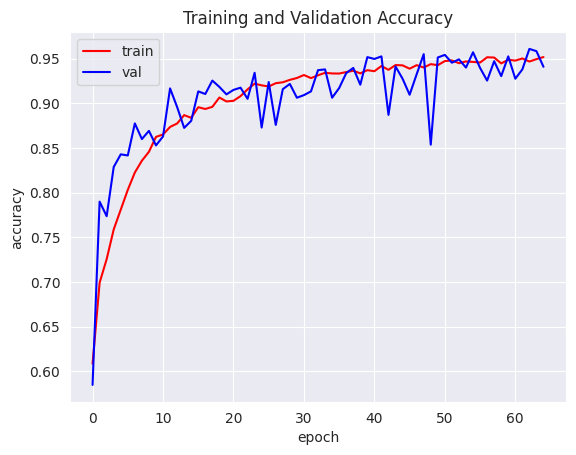

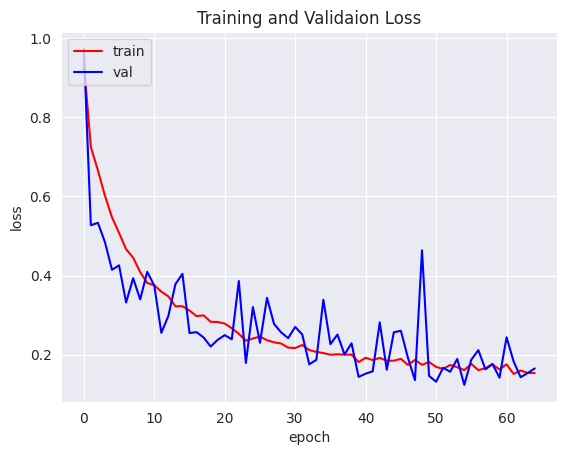

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

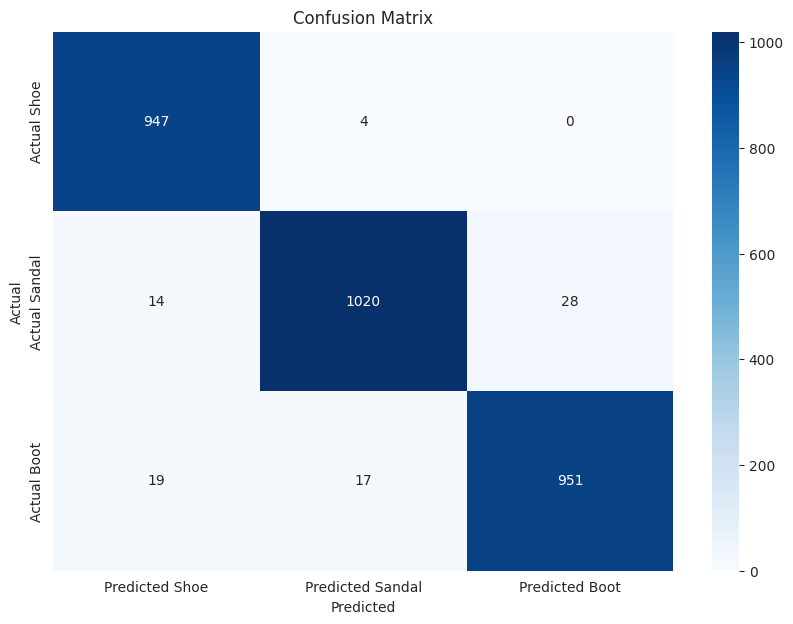


Classification Report:

              precision    recall  f1-score   support

        Shoe     0.9663    0.9958    0.9808       951
      Sandal     0.9798    0.9605    0.9700      1062
        Boot     0.9714    0.9635    0.9674       987

    accuracy                         0.9727      3000
   macro avg     0.9725    0.9733    0.9728      3000
weighted avg     0.9728    0.9727    0.9726      3000



In [ ]:
test_generator.reset()
preds_1 = model_1.predict(test_generator, verbose=0)
pred_classes = np.argmax(preds_1, axis=1)

# True class labels
true_classes = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
cm_df = pd.DataFrame(cm,
    index=["Actual Shoe", "Actual Sandal", "Actual Boot"],
    columns=["Predicted Shoe", "Predicted Sandal", "Predicted Boot"])

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true=true_classes,
                            y_pred=pred_classes,
                            target_names=["Shoe", "Sandal", "Boot"],
                            digits=4))

In [ ]:
# Evaluasi model menggunakan data pengujian
evaluation = model_1.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9858 - loss: 0.0452
Loss: 0.08492226898670197
Accuracy: 0.9726666808128357


Model yang digunakan memiliki akurasi 97,27% terhadap data pengujian.

## Konversi Model

In [ ]:
# Menyimpan model ke format SavedModel

model_1.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137294804480272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804482576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804480848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643742096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643742864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643743248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643744592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643742480: Te

In [ ]:
# Menyimpan model ke format TF-Lite

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmplgx82m_6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137294804480272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804482576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804480848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294804483536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643742096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643742864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643743248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294643744592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13729464374248

In [ ]:
# Menyimpan model ke format TFJS

!pip install tensorflowjs
import tensorflowjs as tfjs
from tensorflow import keras

tfjs.converters.save_keras_model(model_1, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)